In [1]:
# togo_eda.ipynb

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load data
def load_solar_data(file_path):
    """Load and preprocess solar data"""
    df = pd.read_csv(file_path, parse_dates=['Timestamp'])
    df = df.sort_values('Timestamp').reset_index(drop=True)
    return df

# Load your data
df = load_solar_data('../data/togo-dapaong_qc.csv')

In [ ]:
def data_profiling(df):
    """Comprehensive data profiling"""
    print("="*50)
    print("DATA PROFILING REPORT")
    print("="*50)
 
    # Basic info
    print(f"Dataset Shape: {df.shape}")
    print(f"Date Range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
    print(f"Time Resolution: {pd.infer_freq(df['Timestamp'])}")
    
    # Numeric columns summary
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print("\nSummary Statistics:")
    print(df[numeric_cols].describe())
    
    # Missing value analysis
    print("\nMISSING VALUE ANALYSIS:")
    missing_report = pd.DataFrame({
        'Missing_Count': df.isna().sum(),
        'Missing_Percentage': (df.isna().sum() / len(df)) * 100
    })
    print(missing_report)
    
    # Flag columns with >5% nulls
    high_missing = missing_report[missing_report['Missing_Percentage'] > 5]
    if not high_missing.empty:
        print(f"\nColumns with >5% missing values:")
        print(high_missing)
    
    return numeric_cols, high_missing

numeric_cols, high_missing_cols = data_profiling(df)

DATA PROFILING REPORT
Dataset Shape: (525600, 19)
Date Range: 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Time Resolution: min

Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      230.555040     151.258469     116.444352     226.144375   
std       322.532347     250.956962     156.520714     317.346938   
min       -12.700000       0.000000       0.000000       0.000000   
25%        -2.200000       0.000000       0.000000       0.000000   
50%         2.100000       0.000000       2.500000       4.400000   
75%       442.400000     246.400000     215.700000     422.525000   
max      1424.000000    1004.500000     805.700000    1380.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      219.568588      27.751788      55.013160       2.368093   
std       307.932510    

In [5]:
def detect_outliers_zscore(df, columns, threshold=3):
    """Detect outliers using Z-score method"""
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outlier_flags[f'{col}_outlier'] = z_scores > threshold
    
    df['outlier_flag'] = outlier_flags.any(axis=1)
    return df, outlier_flags

def clean_solar_data(df):
    """Comprehensive data cleaning pipeline"""
    df_clean = df.copy()
    
    # Key columns for analysis
    key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust', 'Tamb', 'RH']
    
    # 1. Handle missing values
    for col in key_columns:
        if col in df_clean.columns:
            # For sensor data, use forward fill then median
            if df_clean[col].isna().sum() > 0:
                if col in ['ModA', 'ModB', 'WS', 'WSgust']:
                    df_clean[col] = df_clean[col].fillna(method='ffill').fillna(df_clean[col].median())
                else:
                    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # 2. Detect outliers
    outlier_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
    df_clean, outlier_flags = detect_outliers_zscore(df_clean, outlier_columns)
    
    print(f"Outliers detected: {df_clean['outlier_flag'].sum()} ({df_clean['outlier_flag'].mean()*100:.2f}%)")
    
    # 3. Remove physically impossible values
    if 'GHI' in df_clean.columns:
        df_clean = df_clean[df_clean['GHI'] >= 0]
    if 'Tamb' in df_clean.columns:
        df_clean = df_clean[df_clean['Tamb'].between(-50, 60)]  # Reasonable temp range
    if 'RH' in df_clean.columns:
        df_clean = df_clean[df_clean['RH'].between(0, 100)]
    
    return df_clean, outlier_flags

# Apply cleaning
df_clean, outlier_flags = clean_solar_data(df)

# Export cleaned data
df_clean.to_csv('../data/togo_clean.csv', index=False)

Outliers detected: 9251 (1.76%)


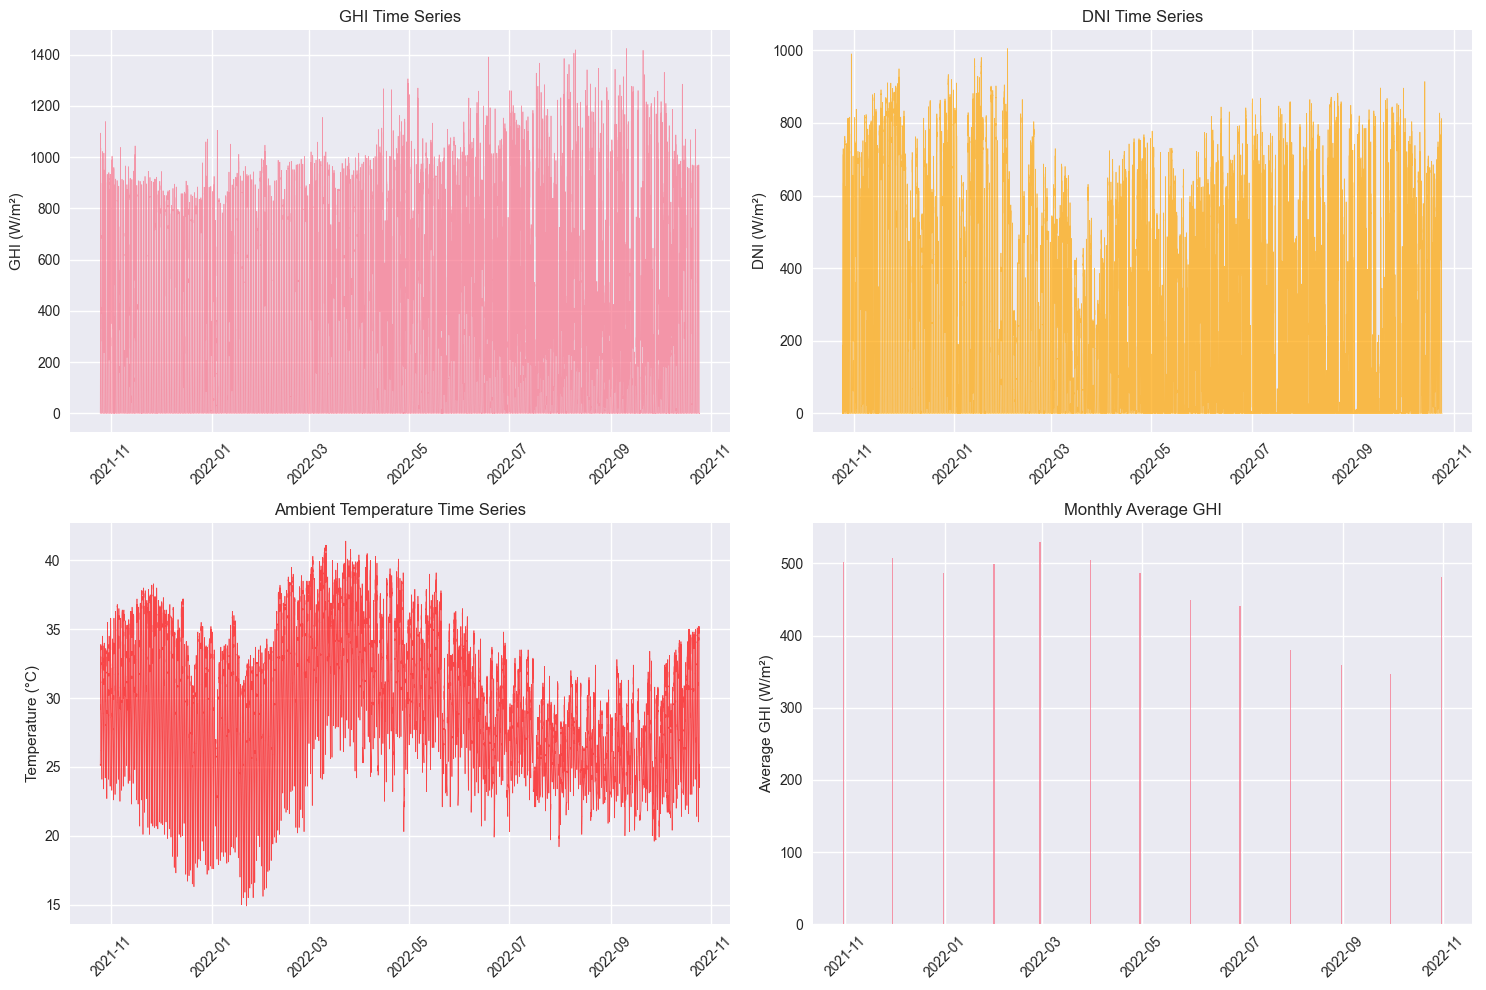

In [6]:
def time_series_analysis(df):
    """Comprehensive time series analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # GHI over time
    if 'GHI' in df.columns:
        axes[0,0].plot(df['Timestamp'], df['GHI'], alpha=0.7, linewidth=0.5)
        axes[0,0].set_title('GHI Time Series')
        axes[0,0].set_ylabel('GHI (W/m²)')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # DNI over time
    if 'DNI' in df.columns:
        axes[0,1].plot(df['Timestamp'], df['DNI'], alpha=0.7, linewidth=0.5, color='orange')
        axes[0,1].set_title('DNI Time Series')
        axes[0,1].set_ylabel('DNI (W/m²)')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Temperature over time
    if 'Tamb' in df.columns:
        axes[1,0].plot(df['Timestamp'], df['Tamb'], alpha=0.7, linewidth=0.5, color='red')
        axes[1,0].set_title('Ambient Temperature Time Series')
        axes[1,0].set_ylabel('Temperature (°C)')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Monthly aggregation
    if 'GHI' in df.columns:
        monthly_ghi = df.set_index('Timestamp')['GHI'].resample('M').mean()
        axes[1,1].bar(monthly_ghi.index, monthly_ghi.values, alpha=0.7)
        axes[1,1].set_title('Monthly Average GHI')
        axes[1,1].set_ylabel('Average GHI (W/m²)')
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

time_series_analysis(df_clean)

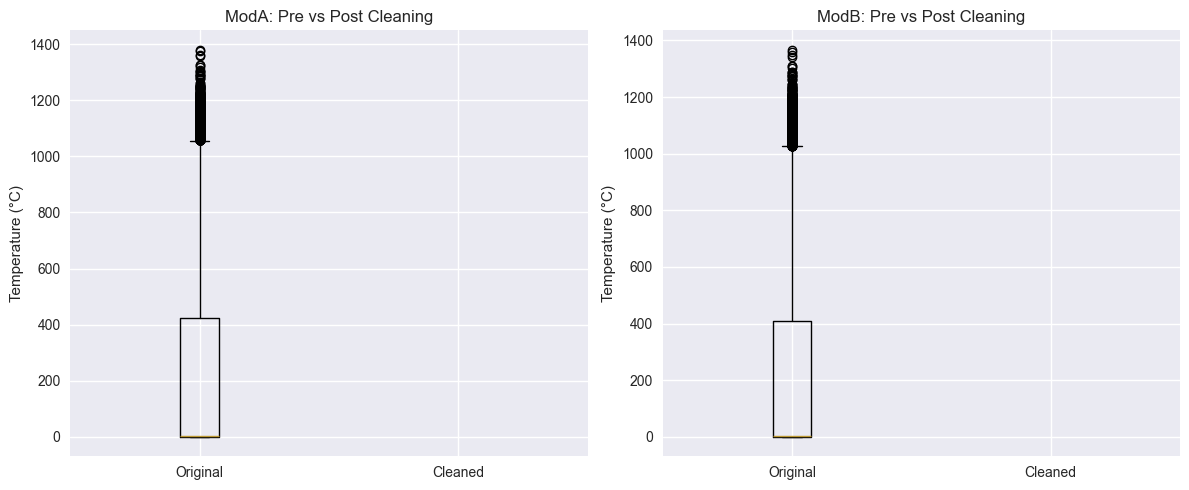

Statistical Comparison:

ModA:
  Original - Mean: 226.14, Std: 317.35
  Cleaned  - Mean: 443.11, Std: 318.16

ModB:
  Original - Mean: 219.57, Std: 307.93
  Cleaned  - Mean: 430.22, Std: 308.54


In [7]:
def cleaning_impact_analysis(df_original, df_cleaned):
    """Analyze impact of cleaning on sensor readings"""
    # Merge original and cleaned data with flags
    comparison = pd.DataFrame({
        'original_ModA': df_original['ModA'],
        'cleaned_ModA': df_cleaned['ModA'],
        'original_ModB': df_original['ModB'],
        'cleaned_ModB': df_cleaned['ModB'],
        'is_cleaned': df_cleaned['outlier_flag']
    })
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # ModA comparison
    axes[0].boxplot([comparison['original_ModA'], comparison['cleaned_ModA']], 
                   labels=['Original', 'Cleaned'])
    axes[0].set_title('ModA: Pre vs Post Cleaning')
    axes[0].set_ylabel('Temperature (°C)')
    
    # ModB comparison
    axes[1].boxplot([comparison['original_ModB'], comparison['cleaned_ModB']], 
                   labels=['Original', 'Cleaned'])
    axes[1].set_title('ModB: Pre vs Post Cleaning')
    axes[1].set_ylabel('Temperature (°C)')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("Statistical Comparison:")
    for sensor in ['ModA', 'ModB']:
        orig = comparison[f'original_{sensor}']
        clean = comparison[f'cleaned_{sensor}']
        print(f"\n{sensor}:")
        print(f"  Original - Mean: {orig.mean():.2f}, Std: {orig.std():.2f}")
        print(f"  Cleaned  - Mean: {clean.mean():.2f}, Std: {clean.std():.2f}")

cleaning_impact_analysis(df, df_clean)

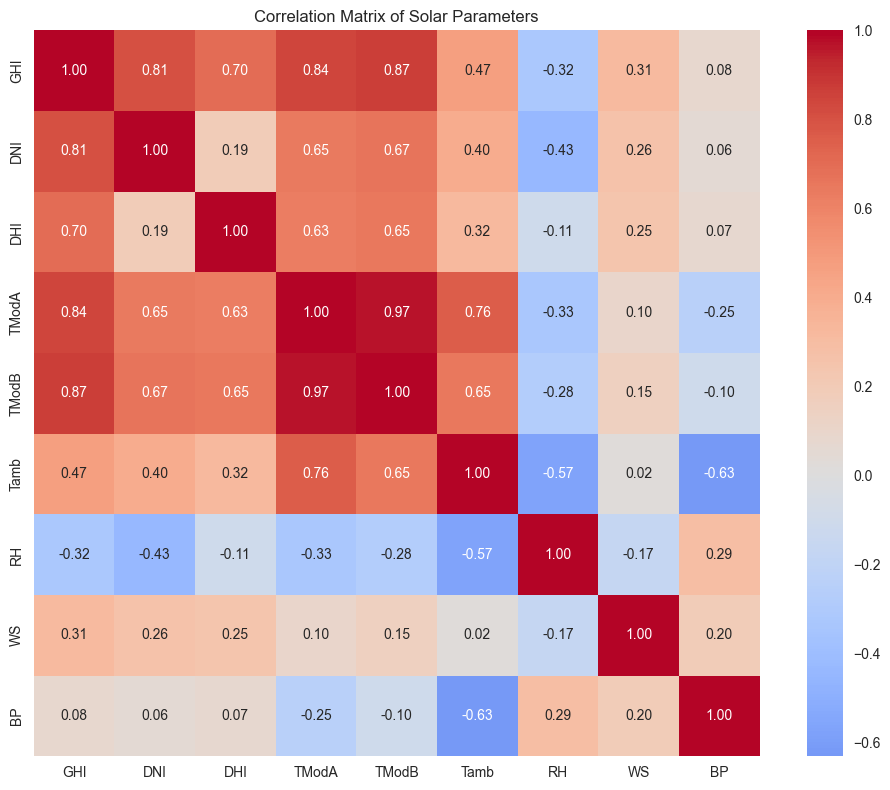

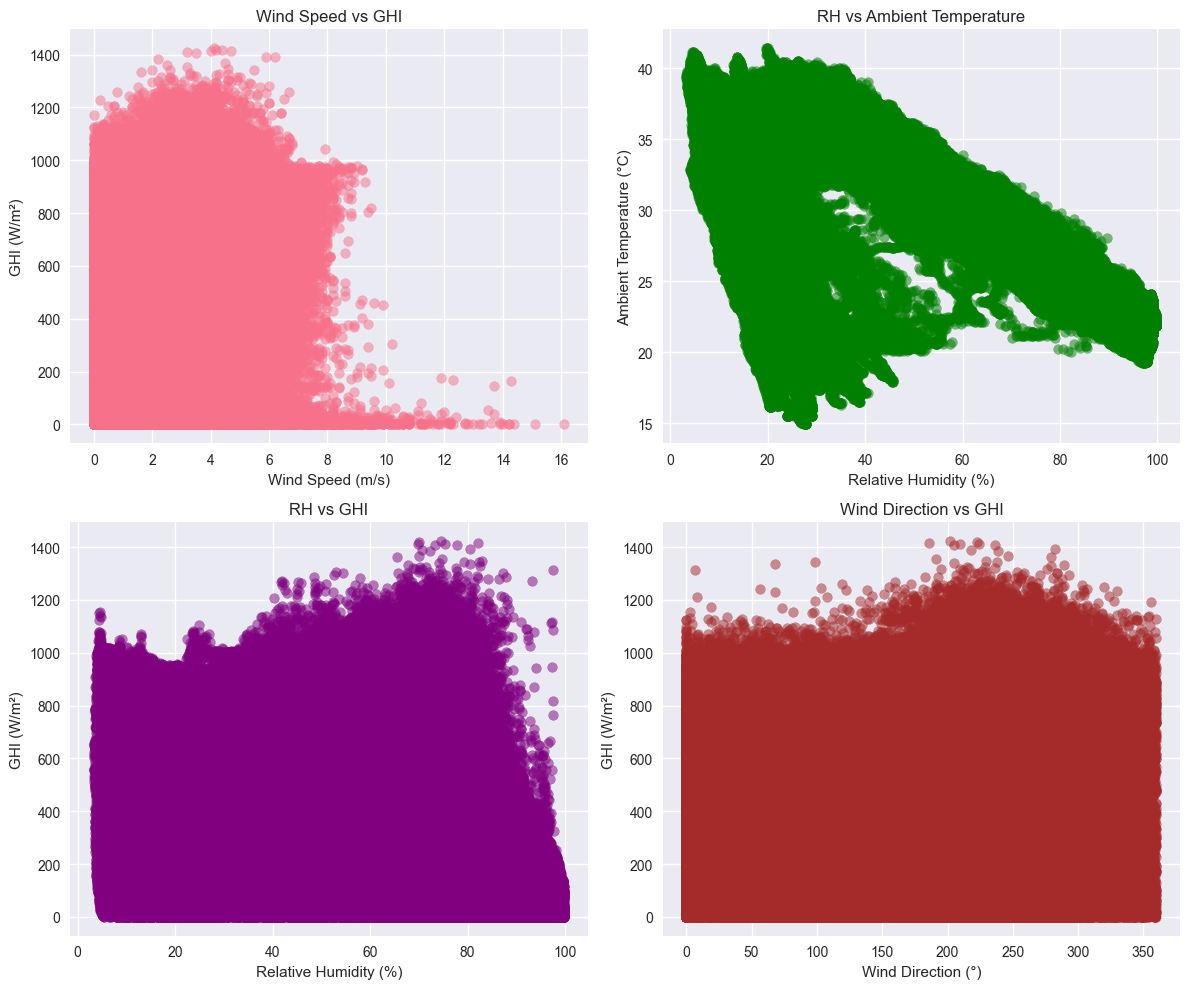

In [8]:
def correlation_analysis(df):
    """Comprehensive correlation and relationship analysis"""
    # Correlation heatmap
    corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'BP']
    available_cols = [col for col in corr_columns if col in df.columns]
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[available_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Correlation Matrix of Solar Parameters')
    plt.tight_layout()
    plt.show()
    
    # Scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # WS vs GHI
    if all(col in df.columns for col in ['WS', 'GHI']):
        axes[0,0].scatter(df['WS'], df['GHI'], alpha=0.5)
        axes[0,0].set_xlabel('Wind Speed (m/s)')
        axes[0,0].set_ylabel('GHI (W/m²)')
        axes[0,0].set_title('Wind Speed vs GHI')
    
    # RH vs Tamb
    if all(col in df.columns for col in ['RH', 'Tamb']):
        axes[0,1].scatter(df['RH'], df['Tamb'], alpha=0.5, color='green')
        axes[0,1].set_xlabel('Relative Humidity (%)')
        axes[0,1].set_ylabel('Ambient Temperature (°C)')
        axes[0,1].set_title('RH vs Ambient Temperature')
    
    # RH vs GHI
    if all(col in df.columns for col in ['RH', 'GHI']):
        axes[1,0].scatter(df['RH'], df['GHI'], alpha=0.5, color='purple')
        axes[1,0].set_xlabel('Relative Humidity (%)')
        axes[1,0].set_ylabel('GHI (W/m²)')
        axes[1,0].set_title('RH vs GHI')
    
    # WD vs GHI (if wind direction available)
    if 'WD' in df.columns and 'GHI' in df.columns:
        axes[1,1].scatter(df['WD'], df['GHI'], alpha=0.5, color='brown')
        axes[1,1].set_xlabel('Wind Direction (°)')
        axes[1,1].set_ylabel('GHI (W/m²)')
        axes[1,1].set_title('Wind Direction vs GHI')
    
    plt.tight_layout()
    plt.show()

correlation_analysis(df_clean)

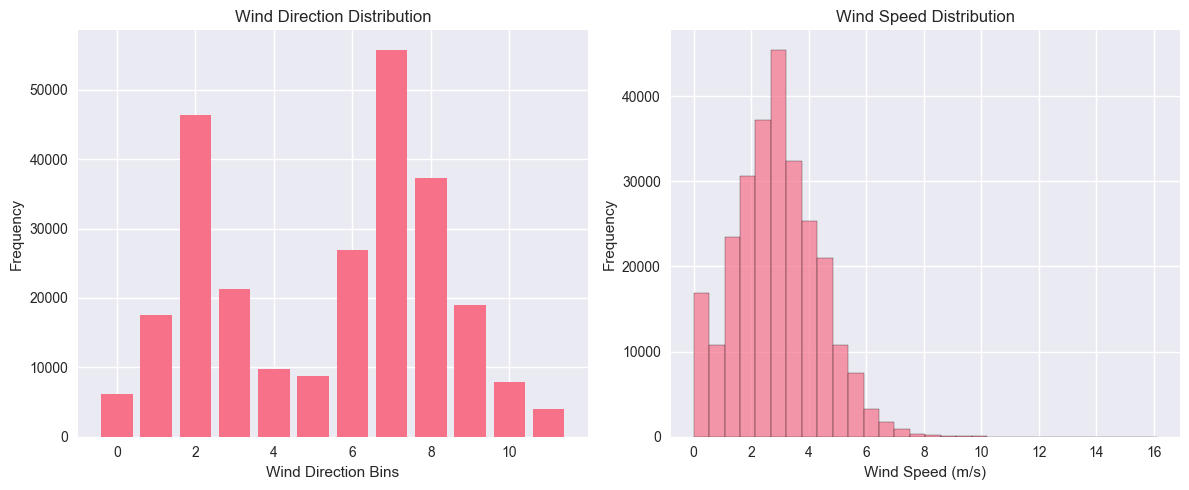

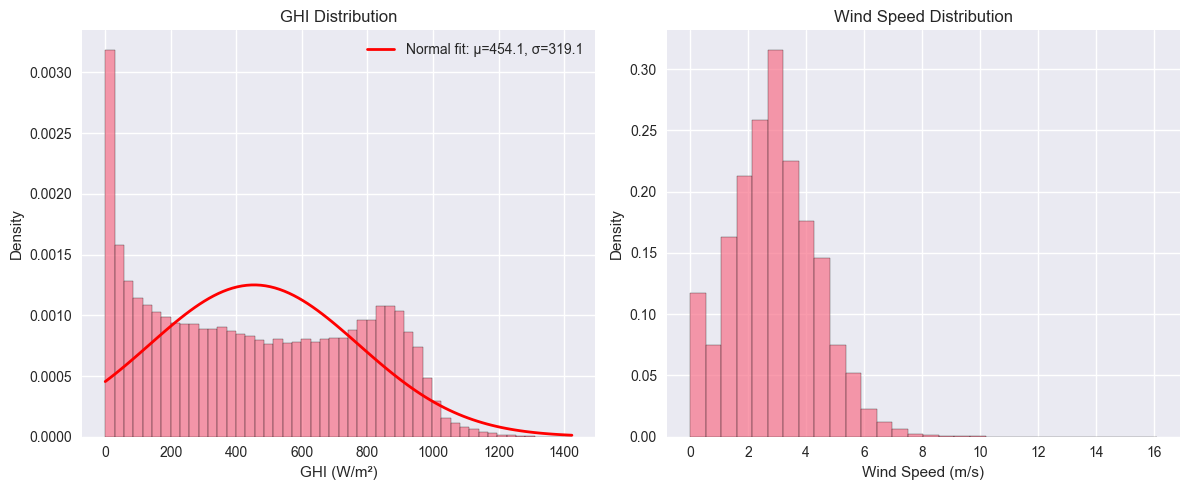

In [9]:
def wind_analysis(df):
    """Wind speed and direction analysis"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Wind rose simulation (simplified)
    if 'WD' in df.columns and 'WS' in df.columns:
        # Create wind direction bins
        wd_bins = np.linspace(0, 360, 13)
        ws_bins = [0, 2, 5, 10, 15, 20]  # m/s
        
        # Group by wind direction and speed
        df_wind = df.copy()
        df_wind['wd_bin'] = pd.cut(df_wind['WD'], bins=wd_bins)
        df_wind['ws_bin'] = pd.cut(df_wind['WS'], bins=ws_bins)
        
        # Plot wind direction distribution
        wind_dir_counts = df_wind['wd_bin'].value_counts().sort_index()
        axes[0].bar(range(len(wind_dir_counts)), wind_dir_counts.values)
        axes[0].set_title('Wind Direction Distribution')
        axes[0].set_xlabel('Wind Direction Bins')
        axes[0].set_ylabel('Frequency')
    
    # Wind speed histogram
    if 'WS' in df.columns:
        axes[1].hist(df['WS'].dropna(), bins=30, alpha=0.7, edgecolor='black')
        axes[1].set_title('Wind Speed Distribution')
        axes[1].set_xlabel('Wind Speed (m/s)')
        axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def distribution_analysis(df):
    """Distribution analysis of key variables"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # GHI distribution
    if 'GHI' in df.columns:
        axes[0].hist(df['GHI'].dropna(), bins=50, alpha=0.7, edgecolor='black', density=True)
        axes[0].set_title('GHI Distribution')
        axes[0].set_xlabel('GHI (W/m²)')
        axes[0].set_ylabel('Density')
        
        # Fit normal distribution
        ghi_clean = df['GHI'].dropna()
        mu, std = stats.norm.fit(ghi_clean)
        x = np.linspace(ghi_clean.min(), ghi_clean.max(), 100)
        p = stats.norm.pdf(x, mu, std)
        axes[0].plot(x, p, 'r-', linewidth=2, label=f'Normal fit: μ={mu:.1f}, σ={std:.1f}')
        axes[0].legend()
    
    # WS distribution
    if 'WS' in df.columns:
        axes[1].hist(df['WS'].dropna(), bins=30, alpha=0.7, edgecolor='black', density=True)
        axes[1].set_title('Wind Speed Distribution')
        axes[1].set_xlabel('Wind Speed (m/s)')
        axes[1].set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

wind_analysis(df_clean)
distribution_analysis(df_clean)

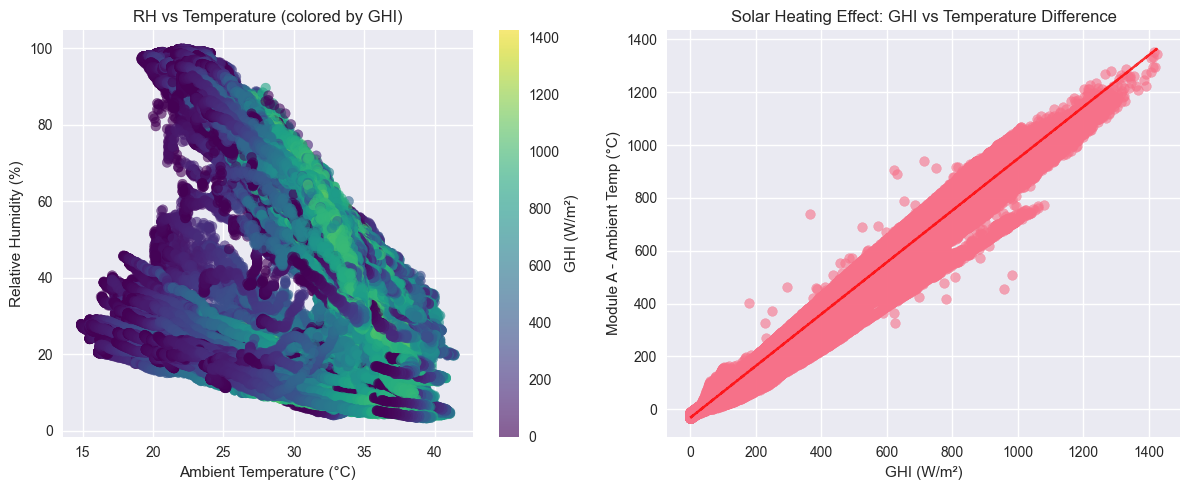

In [10]:
def temperature_rh_analysis(df):
    """Temperature and relative humidity relationship analysis"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # RH vs Temperature
    if all(col in df.columns for col in ['RH', 'Tamb']):
        scatter = axes[0].scatter(df['Tamb'], df['RH'], c=df['GHI'] if 'GHI' in df.columns else None,
                                alpha=0.6, cmap='viridis')
        axes[0].set_xlabel('Ambient Temperature (°C)')
        axes[0].set_ylabel('Relative Humidity (%)')
        axes[0].set_title('RH vs Temperature (colored by GHI)')
        if 'GHI' in df.columns:
            plt.colorbar(scatter, ax=axes[0], label='GHI (W/m²)')
    
    # Temperature effect on solar modules
    if all(col in df.columns for col in ['Tamb', 'ModA', 'GHI']):
        # Calculate temperature difference
        temp_diff = df['ModA'] - df['Tamb']
        axes[1].scatter(df['GHI'], temp_diff, alpha=0.6)
        axes[1].set_xlabel('GHI (W/m²)')
        axes[1].set_ylabel('Module A - Ambient Temp (°C)')
        axes[1].set_title('Solar Heating Effect: GHI vs Temperature Difference')
        
        # Add trend line
        z = np.polyfit(df['GHI'].dropna(), temp_diff.dropna(), 1)
        p = np.poly1d(z)
        axes[1].plot(df['GHI'], p(df['GHI']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()

temperature_rh_analysis(df_clean)

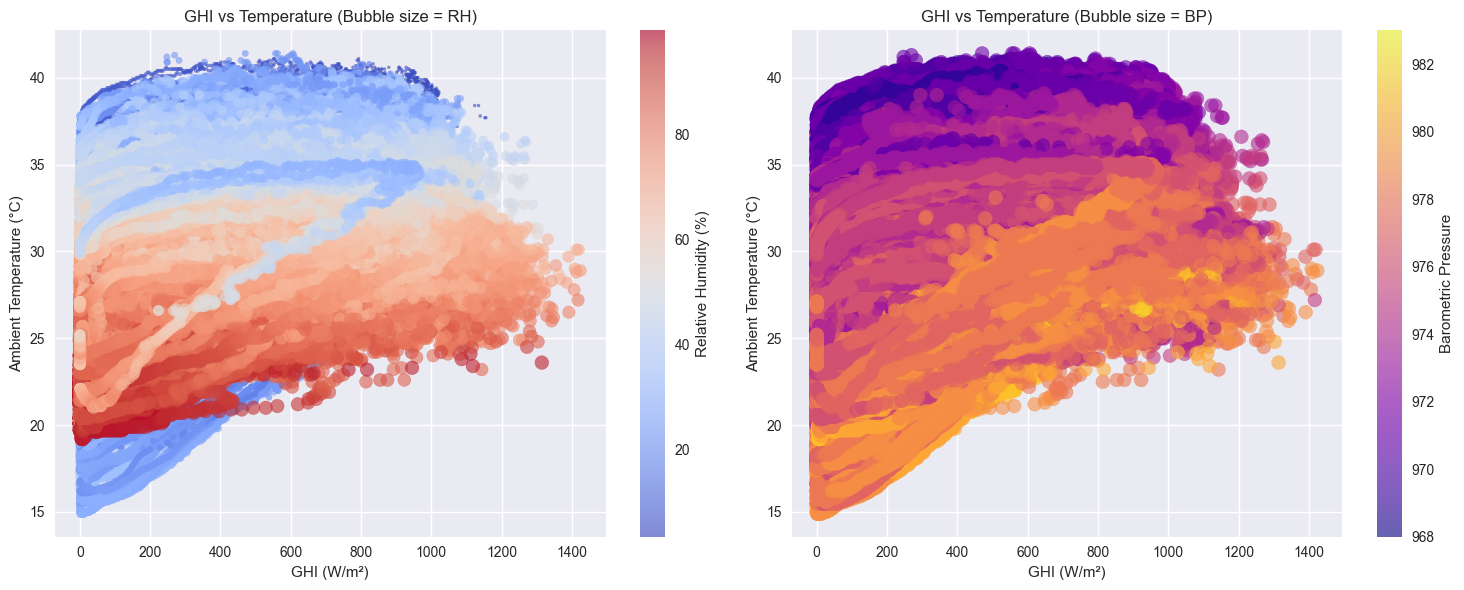

In [11]:
def bubble_chart_analysis(df):
    """Create bubble charts for multivariate analysis"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # GHI vs Tamb with RH as bubble size
    if all(col in df.columns for col in ['GHI', 'Tamb', 'RH']):
        # Normalize RH for bubble sizes
        bubble_sizes = (df['RH'] / df['RH'].max() * 100)
        
        scatter1 = axes[0].scatter(df['GHI'], df['Tamb'], s=bubble_sizes, 
                                 alpha=0.6, c=df['RH'], cmap='coolwarm')
        axes[0].set_xlabel('GHI (W/m²)')
        axes[0].set_ylabel('Ambient Temperature (°C)')
        axes[0].set_title('GHI vs Temperature (Bubble size = RH)')
        plt.colorbar(scatter1, ax=axes[0], label='Relative Humidity (%)')
    
    # GHI vs Tamb with BP as bubble size
    if all(col in df.columns for col in ['GHI', 'Tamb', 'BP']):
        bubble_sizes2 = (df['BP'] / df['BP'].max() * 100)
        
        scatter2 = axes[1].scatter(df['GHI'], df['Tamb'], s=bubble_sizes2, 
                                 alpha=0.6, c=df['BP'], cmap='plasma')
        axes[1].set_xlabel('GHI (W/m²)')
        axes[1].set_ylabel('Ambient Temperature (°C)')
        axes[1].set_title('GHI vs Temperature (Bubble size = BP)')
        plt.colorbar(scatter2, ax=axes[1], label='Barometric Pressure')
    
    plt.tight_layout()
    plt.show()

bubble_chart_analysis(df_clean)

In [12]:
def generate_insights_summary(df):
    """Generate actionable insights from EDA"""
    print("="*60)
    print("ACTIONABLE INSIGHTS SUMMARY")
    print("="*60)
    
    insights = []
    
    # Data Quality Insights
    initial_shape = len(df)
    clean_shape = len(df_clean)
    data_loss = ((initial_shape - clean_shape) / initial_shape) * 100
    
    insights.append(f"Data Quality: {data_loss:.2f}% of data removed during cleaning")
    
    # Solar Resource Insights
    if 'GHI' in df.columns:
        avg_ghi = df_clean['GHI'].mean()
        max_ghi = df_clean['GHI'].max()
        insights.append(f"Solar Resource: Average GHI = {avg_ghi:.1f} W/m², Max = {max_ghi:.1f} W/m²")
    
    # Temperature Insights
    if 'Tamb' in df.columns and 'ModA' in df.columns:
        avg_temp_diff = (df_clean['ModA'] - df_clean['Tamb']).mean()
        insights.append(f"Module Heating: Average module heating = {avg_temp_diff:.1f}°C above ambient")
    
    # Wind Insights
    if 'WS' in df.columns:
        avg_wind = df_clean['WS'].mean()
        max_wind = df_clean['WS'].max()
        insights.append(f"Wind Conditions: Average speed = {avg_wind:.1f} m/s, Max gust = {max_wind:.1f} m/s")
    
    # Correlation Insights
    if all(col in df.columns for col in ['GHI', 'Tamb']):
        ghi_temp_corr = df_clean['GHI'].corr(df_clean['Tamb'])
        insights.append(f"Relationships: GHI-Temperature correlation = {ghi_temp_corr:.2f}")
    
    if all(col in df.columns for col in ['GHI', 'RH']):
        ghi_rh_corr = df_clean['GHI'].corr(df_clean['RH'])
        insights.append(f"Relationships: GHI-RH correlation = {ghi_rh_corr:.2f}")
    
    # Print insights
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    return insights

insights = generate_insights_summary(df)

ACTIONABLE INSIGHTS SUMMARY
1. Data Quality: 48.97% of data removed during cleaning
2. Solar Resource: Average GHI = 454.1 W/m², Max = 1424.0 W/m²
3. Module Heating: Average module heating = 413.2°C above ambient
4. Wind Conditions: Average speed = 2.9 m/s, Max gust = 16.1 m/s
5. Relationships: GHI-Temperature correlation = 0.47
6. Relationships: GHI-RH correlation = -0.32
